In [129]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

% matplotlib inline

rc('text', usetex=True)
sns.set_style("whitegrid", {'axes.grid' : False})

# Exercise 4
Write a program for the control problem in exercise 3.

## Exercise 4 (a)

By varying $\nu, T$, study numerically how the optimal control depends on these parameters.

## Exercise 4 (b)

Explain in words the delayed choice mechanism.

# Exercise 5

Consider the mountain car problem. A car is at the bottom of a valey and can accelerate forward or backwards. The problem is to find a control strategy that gets the car out of the value. $L(x) = -1 -\frac{1}{2} (\tanh(2 x + 2) - \tanh(2x - 2))$ is the shape of the valey. Gravitational force is $F_g = -g \sin \alpha$, with $\tan \alpha = L' = \frac{dL}{dx}$ the slope. Since $-\frac{\pi}{2} < \alpha < \frac{\pi}{2}$ we have $\cos \alpha = \sqrt{1 - \sin^2 \alpha}$ and

$\begin{align}
F_g(x) = -g \frac{L'(x)}{\sqrt{1 + L'^2(x)}}
\end{align}$

The second order system is described by position $x$ and velocity $v$. The dynamics is

$\begin{align}
dx &= v dt\\
dv &= F_g(x) dt + u dt + d\xi
\end{align}$

The cost is

$\begin{align}
C(u) = \langle \phi(x(T) + \int\limits_0^T dt \frac{R}{2} u^2\rangle
\end{align}$

with $\phi(x) = 0$ for $x_{\min} < x < x_{\max}$ and $\phi(x)=A$ otherwise. Take $A = -1$ and $-x_\min=x_\max = 2$, $R = \nu = T = g = 1$. Feel free to change the values.

### Visualize the valey ($L(x)$)

In the next cell, the valey is visualized.

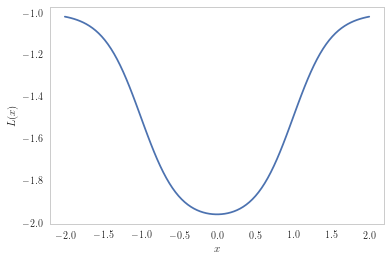

In [130]:
def L(x):
    # The definition of the valey
    return -1 - 0.5 * (np.tanh(2 * x + 2) - np.tanh(2 * x - 2))

x = np.linspace(-2, 2, 100)

plt.plot(x, L(x))
plt.xlabel('$x$')
plt.ylabel('$L(x)$')

### Visualize $L'(x)$
The slope of the valey is needed for the computation of the Gravitation Force. Here, the derivative is calculated and shown.

$\begin{align}
L'(x) &= \frac{\partial L}{\partial x} \big( -1 -\frac{1}{2} (\tanh(2 x + 2) - \tanh(2x - 2)) \big)\\
&= sech^2(2x + 2) - sech^2(2x - 2)
\end{align}$

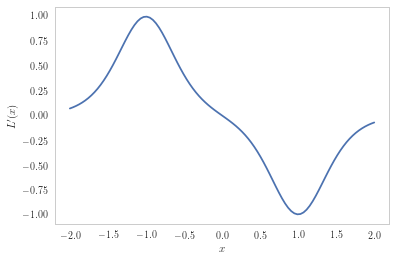

In [131]:
def sech(x):
    # The sech function
    return 2. / (np.exp(x) + np.exp(-x))

def dLdx(x):
    # dL / dx evaluated at point x
    return np.power(sech(2 * x + 2), 2) - np.power(sech(2 * x - 2), 2)

x = np.linspace(-2, 2, 100)
plt.plot(x, dLdx(x))
plt.xlabel('$x$')
plt.ylabel('$L\'(x)$')

So indeed, the derivative vanishes at the endpoints and in the middle and the optima are between the midpoint and the endpoints.

### Visualize Gravitational Force ($F_g$)
Below, the Gravitational Force is defined and visualized.

$\begin{align}
F_g(x) &= -g \frac{L'(x)}{\sqrt{1 + L'^2(x)}}\\
\end{align}$

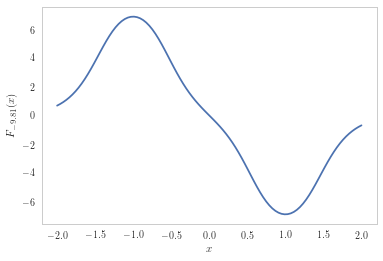

In [132]:
def F(x, g):
    # The gravitational force
    return -g * dLdx(x) / np.sqrt(1 + np.power(dLdx(x), 2))

x = np.linspace(-2, 2, 100)
plt.plot(x, F(x, -9.81))
plt.xlabel('$x$')
plt.ylabel('$F_{-9.81}(x)$')

In [141]:
class MountainCarProblem:
    
    def __init__(self, x_0, v_0, A=-1, R=1, nu=1, T=1, g=1, dt=0.01, u=0, t_0=0):
        """
        Initialize the Mountain Car Problem.
        
        x_0: The initial position.
        v_0: The initial velocity.
        A:   The reward for ending outside the valey (default: -1).
        R:   Relation between the noise level and the optimal control (default: 1).
        nu:  Noise level.
        T:   Horizon.
        g:   Gravitational constant (default: 1).
        u:   Constant control (default: 0). For dynamic control, implement the compute_control method.
        t_0: The start time of the system such that 0 <= t_0 <= T (default: t_0=0).
        """
        self.x_0, self.v_0, self.A, self.R, self.nu, self.T, self.g, self.dt, self.u, self.t_0 = x_0, v_0, A, R, nu, T, g, dt, u, t_0
        self.x_min, self.x_max = -2, 2
        self.x = self.x_0
        self.v = self.v_0
        self.t = self.t_0
        
    def run(self):
        """
        Run the simulation. It will return the following result:
        
        [xs, vs, ts, dus, dxis] in which:
        xs:   The computed positions over time.
        vs:   The computed velocities over time.
        ts:   The computed times (simply ranging from 0 to T).
        dus:  The computed controls over time.
        dxis: The computed noise per timestep.
        """
        xs, vs, ts, dus, dxis = [], [], [], [], []
        x, v, t = self.x_0, self.v_0, self.t_0
        steps = math.floor((self.T - self.t_0) / self.dt) + 1
        
        for step in range(steps):
            dudt = self.compute_control()
            noise = 0 if self.nu == 0 else np.random.normal(0, self.nu)
            dxi = np.sqrt(self.dt) * noise
            
            xs.append(x)
            vs.append(v)
            ts.append(t)
            dus.append(dudt)
            dxis.append(dxi)
            
            dx = v * self.dt
            dv = F(x, self.g) * self.dt + dudt + dxi
            
            x += dx
            v += dv
            t += self.dt
            
            self.x = x
            self.v = v
            self.t = t
            
        phi = 0 if self.x_min < self.x and self.x < self.x_max else self.A
            
        return xs, vs, ts, dus, dxis, phi
        
    def compute_control(self):
        """
        Compute the control. This method has access to state variables self.x (position), self.v (velocity) and self.t (time).
        """
        return self.u

## Exercise 5 (a)
Take $x(0) = 0.5$ and $v(0) = 0$. Simulate the uncontrolled dynamics and vary the parameters such that 1) the problem is too easy and all trajectories reach the top of the hill and 2) the problem is not too hard that no trajectories reach the top of the hill.

### High inverse gravity, no noise: $g=10, \nu=0$

In [134]:
print('Run simulation g=10, nu=0 multiple times')
for _ in range(10):
    mcp = MountainCarProblem(0.5, 0, A=-1, R=1, nu=0, T=1, g=10)
    xs, vs, ts, dus, dxis, phi = mcp.run()
    print('Reached the top' if phi != 0 else 'Did not reach the top')

Run simulation g=10, nu=0 multiple times
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top


### High inverse gravity, hight noise: $g=10, \nu=20$

In [135]:
print('Run simulation g=10, nu=10 multiple times')
for _ in range(10):
    mcp = MountainCarProblem(0.5, 0, A=-1, R=1, nu=20, T=1, g=10)
    xs, vs, ts, dus, dxis, phi = mcp.run()
    print('Reached the top' if phi != 0 else 'Did not reach the top')

Run simulation g=10, nu=10 multiple times
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top


### No gravity, no noise, no control: $g=0, \nu=0, u=0$

In [136]:
print('Run simulation g=0, nu=0, u=0 multiple times')
for _ in range(10):
    mcp = MountainCarProblem(0.5, 0, A=-1, R=1, nu=0, T=1, g=0, u=0)
    xs, vs, ts, dus, dxis, phi = mcp.run()
    print('Reached the top' if phi != 0 else 'Did not reach the top')

Run simulation g=0, nu=0, u=0 multiple times
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top


### No gravity, no noise, large control: $g=0, \nu = 0, u=10$

In [137]:
print('Run simulation g=0, nu=0, u=10 multiple times')
for _ in range(10):
    mcp = MountainCarProblem(0.5, 0, A=-1, R=1, nu=0, T=1, g=0, u=10)
    xs, vs, ts, dus, dxis, phi = mcp.run()
    print('Reached the top' if phi != 0 else 'Did not reach the top')

Run simulation g=0, nu=0, u=10 multiple times
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top
Reached the top


/home/kevin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


### Extreme noise: $\nu \rightarrow \infty$
If the noise is extremely large, we expect that the probability of reaching anything but the valey is extremely likely.

In [138]:
print('Run simulation g=0, nu=999... multiple times')
for _ in range(10):
    mcp = MountainCarProblem(0.5, 0, A=-1, R=1, nu=999, T=1, g=0)
    xs, vs, ts, dus, dxis, phi = mcp.run()
    print('Reached the top' if phi != 0 else 'Did not reach the top')

Run simulation g=0, nu=999... multiple times
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top
Did not reach the top


### Noise versus control (and $g=0$)

In this example, multiple simulations are run per setting and the noise and constant control are compared to the ratio of simulations in which the car escaped the valey.

/home/kevin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


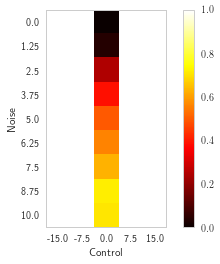

In [142]:
noise = np.linspace(0, 10, 9)
control = np.linspace(-15, 15, 5)
ratios = []

# Number of samples per simulation
num_samples = 100
for nu in noise:
    row = []
    for u in control:
        ratio = 0.
        for _ in range(num_samples):
            mcp = MountainCarProblem(0.5, 0, A=1, R=1, nu=nu, T=1, g=0, u=u)
            xs, vs, ts, dus, dxis, phi = mcp.run()
            ratio += phi / float(num_samples)
        row.append(ratio)
    ratios.append(row)
    
# Show the plot
fig, ax = plt.subplots(1, 1)
plt.imshow(ratios, cmap='hot')
plt.colorbar()
ax.set_xticks(np.arange(control.shape[0]))
ax.set_yticks(np.arange(noise.shape[0]))
ax.set_xticklabels(control)
ax.set_yticklabels(noise)
ax.set_xlabel('Control')
ax.set_ylabel('Noise')

### Simulations

So now we now this, we can run some simulations to see what happens to the state.

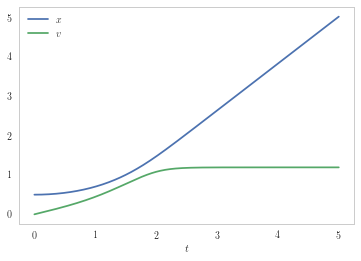

In [144]:
mcp = MountainCarProblem(0.5, 0, A=1, R=1, nu=0, T=5, g=1, u=0)
xs, vs, ts, dus, dxis, phi = mcp.run()
plt.plot(ts, xs, label='$x$')
plt.plot(ts, vs, label='$v$')
plt.xlabel('$t$')
plt.legend()

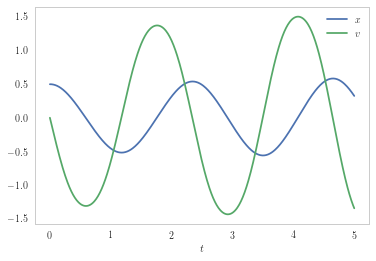

In [145]:
mcp = MountainCarProblem(0.5, 0, A=1, R=1, nu=0, T=5, g=-10, u=0)
xs, vs, ts, dus, dxis, phi = mcp.run()
plt.plot(ts, xs, label='$x$')
plt.plot(ts, vs, label='$v$')
plt.xlabel('$t$')
plt.legend()

/home/kevin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


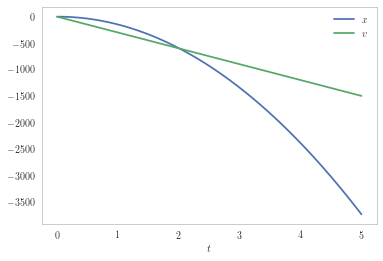

In [146]:
mcp = MountainCarProblem(0.5, 0, A=1, R=1, nu=0, T=5, g=-10, u=-3)
xs, vs, ts, dus, dxis, phi = mcp.run()
plt.plot(ts, xs, label='$x$')
plt.plot(ts, vs, label='$v$')
plt.xlabel('$t$')
plt.legend()

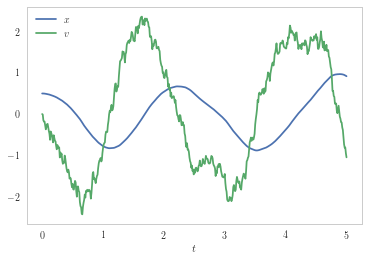

In [147]:
mcp = MountainCarProblem(0.5, 0, A=1, R=1, nu=1, T=5, g=-10, u=0)
xs, vs, ts, dus, dxis, phi = mcp.run()
plt.plot(ts, xs, label='$x$')
plt.plot(ts, vs, label='$v$')
plt.xlabel('$t$')
plt.legend()

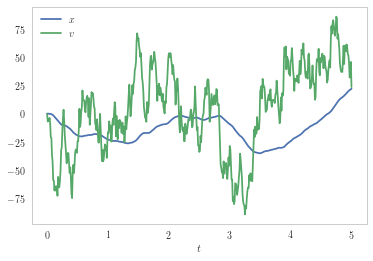

In [148]:
mcp = MountainCarProblem(0.5, 0, A=1, R=1, nu=99, T=5, g=-10, u=0)
xs, vs, ts, dus, dxis, phi = mcp.run()
plt.plot(ts, xs, label='$x$')
plt.plot(ts, vs, label='$v$')
plt.xlabel('$t$')
plt.legend()

#### Many runs with noise ($g=-10$)

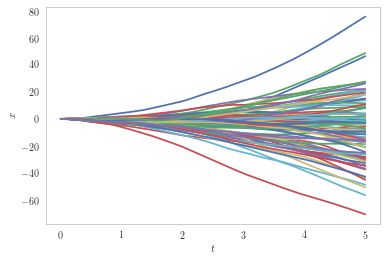

In [200]:
mcp = MountainCarProblem(0.5, 0, A=1, R=1, nu=4, T=5, g=-10, u=0)
for _ in range(100):
    xs, vs, ts, dus, dxis, phi = mcp.run()
    plt.plot(ts, xs)
plt.xlabel('$t$')
plt.ylabel('$x$')

#### Many runs with noise ($g=0$)

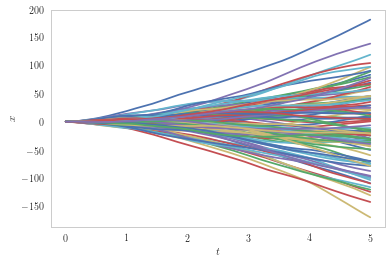

In [197]:
mcp = MountainCarProblem(0.5, 0, A=1, R=1, nu=10, T=5, g=0, u=0)
for _ in range(100):
    xs, vs, ts, dus, dxis, phi = mcp.run()
    plt.plot(ts, xs)
plt.xlabel('$t$')
plt.ylabel('$x$')

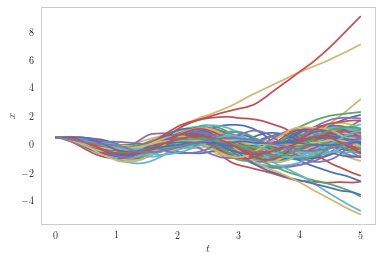

In [196]:
mcp = MountainCarProblem(0.5, 0, A=1, R=1, nu=1, T=5, g=-10, u=0)
for _ in range(100):
    xs, vs, ts, dus, dxis, phi = mcp.run()
    plt.plot(ts, xs)
plt.xlabel('$t$')
plt.ylabel('$x$')

### Conclusions

With no gravity, it is easier to escape the valey because less force is needed in order to escape. The more gravity is added to the problem, the more the car will not escape out of the valey.

With too much noise, it is hard for the car to come back into the valey. Therefore, the probability of escaping the valey increases. Therefore, we will only consider a slight amount of noise during the remainder of the assignment.

With maximal control, it is extremely easy to escape the valey. However, the cost will increasing and therefore this is definitely not an optimal solution to the problem.

Without noise and control, the car will oscilate in the valey and will therefore never escape the valey.

## Exercise 5 (b)
With the parameter values found above, compute the optimal cost to go $J(x, v, t=0)$ for $x = -2:0.1:2$ and $v = -2:0.1:2$ using MCMC. This is done by running $n$ times the uncontrolled dynamics for each $x, v$ pair:

$\begin{align}
J(x, v, t=0) = -\lambda \log \Big(\frac{1}{n} \sum\limits_{\mu = 1}^n \exp(\frac{-\phi \big( x(T) \big)}{\lambda}) \Big)
\end{align}$

Plot $J(x, v, t=0)$. Interpret the result.

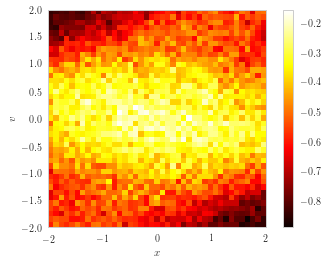

In [270]:
xs = np.linspace(-2, 2, 41)
vs = np.linspace(-2, 2, 41)
n = 100
Js = []

for x in xs:
    row = []
    for v in vs:
        S = 0
        for mu in range(n):
            mcp = MountainCarProblem(x, v, nu=4, g=-10, u=0, A=-1)
            _, _, ts, dus, dxis, phi = mcp.run()
            S += np.exp(-phi)
        S /= n
        J = -np.log(S)
        row.append(J)
    Js.append(row)

fig, ax = plt.subplots(1, 1)
plt.imshow(Js, cmap='hot', extent=(-2, 2, -2, 2))
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$v$')

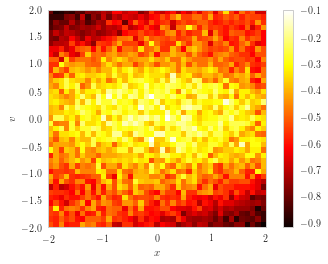

In [269]:
fig, ax = plt.subplots(1, 1)
plt.imshow(Js, cmap='hot', extent=(-2, 2, -2, 2))
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$v$')

(array([ 0.14485903,  0.27764648,  0.1690022 ,  0.03621476,  0.01207159,
         0.14485903,  0.22936013,  0.12071586,  0.06035793,  0.01207159]),
 array([-3.50055091, -2.67215935, -1.84376778, -1.01537621, -0.18698464,
         0.64140693,  1.4697985 ,  2.29819007,  3.12658164,  3.95497321,
         4.78336478]),
 <a list of 10 Patch objects>)

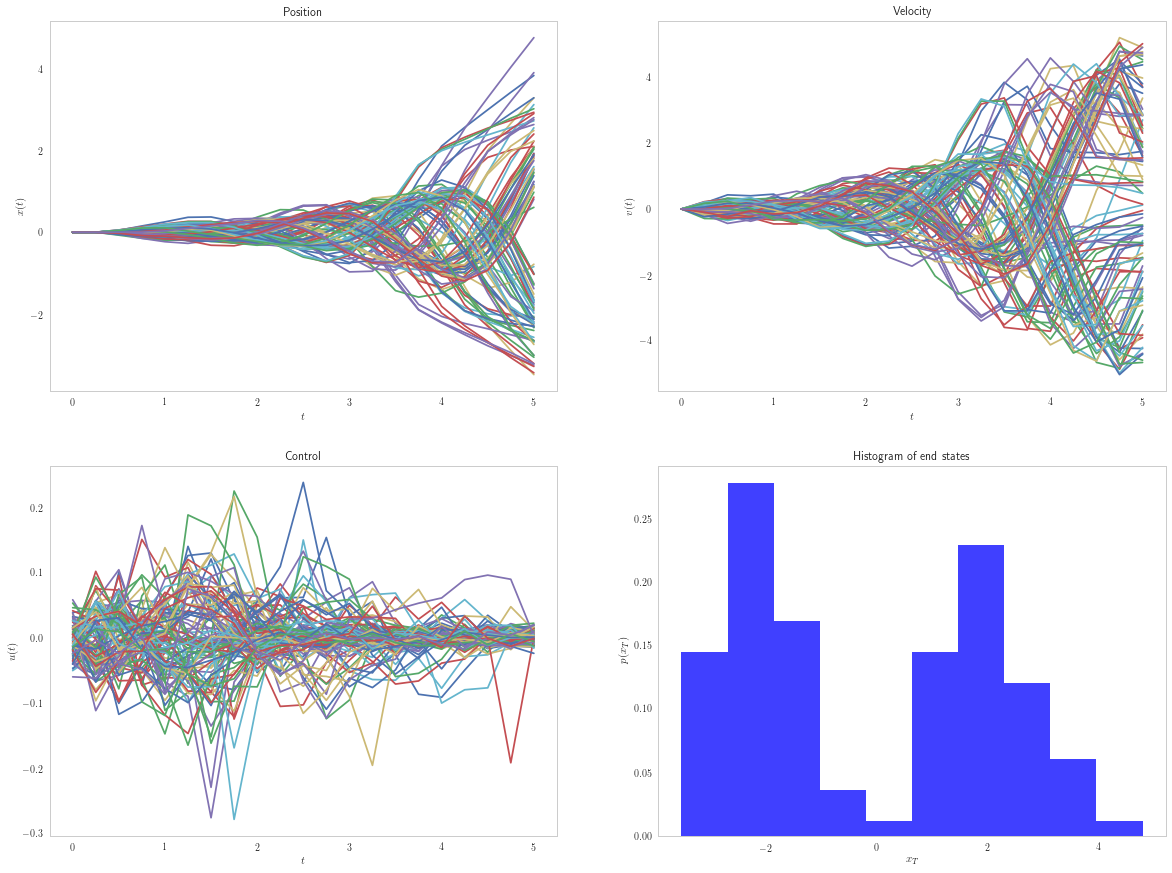

In [194]:
class OptimalControlMCP(MountainCarProblem):
    def run_uncontrolled(self, x, v, t):
        mcp = MountainCarProblem(x_0=x, v_0=v, A=self.A, R=self.R, nu=self.nu, T=self.T, g=self.g, dt=self.dt, u=0, t_0=t)
        return mcp.run()
    
    def compute_control(self):
        #return 0
        w = []
        xi = []
        N = 100
        for _ in range(N):
            xs, vs, ts, dus, dxis, phi = self.run_uncontrolled(self.x, self.v, self.t)
            step = math.floor(self.t / self.dt)
            if len(dxis) > 0:
                dxis = np.asarray(dxis)
                if phi == 0:
                    w.append(0)
                else:
                    w.append(1. / N * np.exp(-phi))
                xi.append(dxis[0])
            else:
                w.append(0)
        w = np.array(w)
        xi = np.array(xi)
        ones = np.ones(w.shape)
        denom = np.dot(w, ones)
        if denom == 0:
            return 0
        udt = np.dot(w, xi) / denom
        return udt
  
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
endstates = []
for _ in range(100):
    mcp = OptimalControlMCP(0, 0, A=-1, R=1, nu=0.2, T=5, g=-10, dt=0.25)
    xs, vs, ts, dus, dxis, phi = mcp.run()
    endstates.append(xs[-1])
    
    ax1.plot(ts, xs)
    ax1.set_title('Position')
    ax1.set_xlabel('$t$')
    ax1.set_ylabel('$x(t)$')
    
    ax2.plot(ts, vs)
    ax2.set_title('Velocity')
    ax2.set_xlabel('$t$')
    ax2.set_ylabel('$v(t)$')
    
    ax3.plot(ts, dus)
    ax3.set_title('Control')
    ax3.set_xlabel('$t$')
    ax3.set_ylabel('$u(t)$')
    
ax4.set_title('Histogram of end states')
ax4.set_xlabel('$x_T$')
ax4.set_ylabel('$p(x_T)$')
ax4.hist(endstates, 10, normed=1, facecolor='blue', alpha=0.75)